In [231]:
import os
import gzip
import pandas as pd
import numpy as np
import re

ROOT = "/group/iorio/lucia/"
FOLD_PROJECT = os.path.join(ROOT, "Multiomic_VAE/")

xena_folder = os.path.join(ROOT, "datasets/XENA/TCGA_TARGET_GTEx/")
# xena_gene_file = os.path.join(xena_folder, "TcgaTargetGtex_rsem_gene_tpm")
xena_gene_file = os.path.join(xena_folder, "TEST_rsem_gene_tpm")
xena_gene_mapping_file = os.path.join(xena_folder, 'probeMap%2Fgencode.v23.annotation.gene.probemap')
xena_sample_file = os.path.join(xena_folder, 'TcgaTargetGTEX_phenotype.txt.gz')

depmap_folder = os.path.join(ROOT, "datasets/DEPMAP_PORTAL/version_23Q2/")
depmap_gene_file = os.path.join(depmap_folder, "OmicsExpressionProteinCodingGenesTPMLogp1.csv")
depmap_sample_file = os.path.join(depmap_folder, "Model.csv")

# gene annotation
hgnc_gene_ann_file = os.path.join(ROOT, "datasets/hgnc_complete_set_202311.txt")
hgnc_gene_ann_df = pd.read_csv(hgnc_gene_ann_file, sep="\t", low_memory=False)

# load depmap data
depmap_gene_df = pd.read_csv(depmap_gene_file, sep=',', index_col=0)
depmap_gene_df.index.name = 'sample_id'
depmap_sample_df = pd.read_csv(depmap_sample_file, sep=',', index_col=0)
depmap_sample_df.index.name = 'sample_id'

# load tissue data
with gzip.open(xena_sample_file) as f:
    xena_sample_df = pd.read_csv(f, sep='\t', index_col=0, encoding='ISO-8859-1')
xena_sample_df.index.name = 'sample_id'
xena_gene_mapping_df = pd.read_csv(xena_gene_mapping_file, sep='\t')

xena_gene_df = pd.read_csv(xena_gene_file, sep='\t')
xena_gene_df.index = xena_gene_df['sample']
xena_gene_df = xena_gene_df.drop(columns=['sample'])
xena_gene_df.index.name = 'xena_gene_id'


In [168]:
########################
### MATCH AND FILTER ###
########################

# match data frames by gene id (use hgnc annotation)
# to get the new gene names, assign to a dataframe and match with the two available annotations!
gene_names = []
gene_ids = []

# Split each element in the array and extract gene name and ID
for column_name in depmap_gene_df.columns:
    parts = re.split(r'\s*\(|\)\s*', column_name)
    gene_name = parts[0].strip()
    gene_id = parts[1].strip()
    gene_names.append(gene_name)
    gene_ids.append(gene_id)

# Create a DataFrame with the gene names and gene IDs as columns
df = pd.DataFrame({'gene_name': gene_names, 'entrez_id': gene_ids})

# match with hgnc
df['entrez_id'] = df['entrez_id'].astype('float64')
match_df = pd.merge(df, 
                    hgnc_gene_ann_df[["hgnc_id", "entrez_id", "symbol", "ensembl_gene_id"]], 
                    on = 'entrez_id')
# match with xena gene mapping
xena_gene_mapping_df['ensembl_gene_id'] = xena_gene_mapping_df['id'].str.split('.').str[0]
match_df = pd.merge(match_df, xena_gene_mapping_df, on = 'ensembl_gene_id')

# remvoe duplicates and modify names
match_df = match_df.drop_duplicates(subset=["ensembl_gene_id"])
match_df['depmap_gene_id'] = match_df['gene_name'] + " (" + match_df['entrez_id'].astype('int').astype('str') + ")"
match_df['xena_gene_id'] = match_df['id']
match_df['complete_id'] = match_df['symbol'] + " (" + match_df['ensembl_gene_id'] + ")"

# create a new data frame from depmap_gene_df, keep only those genes that have a value in depmap_id in match_df
depmap_gene_df_match = depmap_gene_df[match_df['depmap_gene_id']]
depmap_gene_df_match.columns = match_df['complete_id']
depmap_gene_df_match.columns.name = None

# create a new data frame from xena_gene_df, keep only those genes that have a value in xena_id in match_df
xena_gene_df_match = xena_gene_df.loc[match_df['xena_gene_id'], :]
# transpose xena_gene_df_match
xena_gene_df_match = xena_gene_df_match.transpose()
xena_gene_df_match.index.name = 'sample_id'
xena_gene_df_match.columns = match_df['complete_id']
xena_gene_df_match.columns.name = None
# convert entries in xena_gene_df_match: computed as log2(x+0.001) but should be log2(x+1)
xena_gene_df_match = np.log2(np.power(2, xena_gene_df_match) - 0.001 + 1)
xena_gene_df_match[xena_gene_df_match.abs() < 10**-7] = 0

# create final table (samples x genes)
tot_gene_df = pd.concat([depmap_gene_df_match, xena_gene_df_match], axis=0, sort=False)

In [201]:
# create a function to create standard deviation and mean per gene (colum)
def get_mean_std_cv(df):
    std = df.std(axis=0)
    mean = df.mean(axis=0)
    df_summ = pd.DataFrame({'id': df.columns, 'mean': mean, 'std': std})
    df_summ['cv'] =  df_summ['std'] /  df_summ['mean']
    # remove index
    df_summ = df_summ.reset_index(drop=True)
    return df_summ 

df_summary = pd.merge(
    get_mean_std_cv(depmap_gene_df_match), 
    get_mean_std_cv(xena_gene_df_match), 
    on = 'id', 
    suffixes=('_depmap', '_xena'))


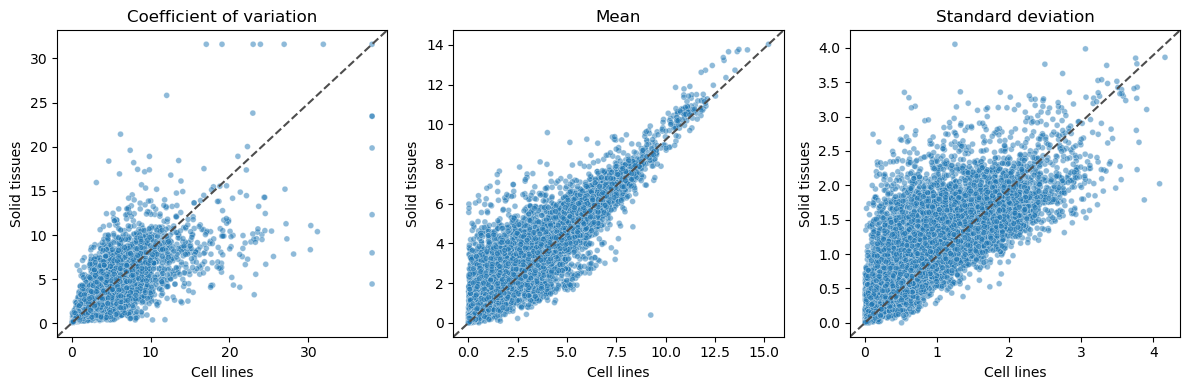

In [233]:
############
### PLOT ###
############

# plot the distribution of the coefficient of variation
import matplotlib.pyplot as plt
import seaborn as sns

# change the size of the plot
fig, axes = plt.subplots(1,3)
plt.rcParams['figure.figsize'] = [12, 4]

sns.scatterplot(data = df_summary, x = "cv_depmap", y = "cv_xena", size = 0.5, alpha = 0.5, ax = axes[0])
sns.scatterplot(data = df_summary, x = "mean_depmap", y = "mean_xena", size = 0.5, alpha = 0.5, ax = axes[1])
sns.scatterplot(data = df_summary, x = "std_depmap", y = "std_xena", size = 0.5, alpha = 0.5, ax = axes[2])
# change labels
axes[0].set_xlabel("Cell lines")
axes[0].set_ylabel("Solid tissues")
axes[1].set_xlabel("Cell lines")
axes[1].set_ylabel("Solid tissues")
axes[2].set_xlabel("Cell lines")
axes[2].set_ylabel("Solid tissues")
# remove legend
axes[0].get_legend().remove()
axes[1].get_legend().remove()
axes[2].get_legend().remove()
# add bisect
axes[0].plot([0, 1], [0, 1], transform=axes[0].transAxes, ls="--", c=".3")
axes[1].plot([0, 1], [0, 1], transform=axes[1].transAxes, ls="--", c=".3")
axes[2].plot([0, 1], [0, 1], transform=axes[2].transAxes, ls="--", c=".3")
# title
axes[0].set_title("Coefficient of variation")
axes[1].set_title("Mean")
axes[2].set_title("Standard deviation")
plt.tight_layout()

plt.savefig(FOLD_PROJECT + "data_preprocessing/plot/GEX_compare_distributions.pdf", format = 'pdf')
